# The Insulin Minimal Model

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

## Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [4]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/data/glucose_insulin.csv')

In [5]:
data = pd.read_csv('glucose_insulin.csv', index_col='time');

## The insulin minimal model

In addition to the glucose minimal mode, Pacini and Bergman present an insulin minimal model, in which the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

**Exercise:**  Write a version of `make_system` that takes the parameters of the model (`I0`, `k`, `gamma`, and `G_T`) as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_solve_ivp`.

Use it to make a `System` object with the following parameters:

In [7]:
I0 = 360   
k = 0.25
gamma = 0.004
G_T = 80
params = I0, k, gamma, G_T

In [8]:
# Solution

def make_system(params, data):
    I0, k, gamma, G_T = params
    
    init = State(I=I0)
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    G=interpolate(data.glucose)
    
    system = System(I0=I0, k=k, gamma=gamma, G_T=G_T, G=G,
                    init=init, t_0=t_0, t_end=t_end, dt=1)

    return system

In [9]:
# Solution

system = make_system(params, data)

**Exercise:** Write a slope function that takes a time stamp, a `State` object, and a `System` object, and returns the derivative of `I` with respect to time.  Test your function with the initial conditions from `system`.

In [10]:
# Solution

def slope_func(t, state, system):
    I = state
    k, gamma = system.k, system.gamma
    G, G_T = system.G, system.G_T
        
    dIdt = -k * I + gamma * (G(t) - G_T) * t
    
    return dIdt

In [11]:
# Solution

slope_func(system.t_0, system.init, system)

I   -90.0
Name: state, dtype: float64

**Exercise:** Run `run_solve_ivp` with your `System` object and slope function, and plot the results, along with the measured insulin levels.

In [12]:
# Solution

results, details = run_solve_ivp(system, slope_func,
                                 t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

In [13]:
# Solution

results.tail()

,I
102,1.937078
122,3.415175
142,4.434037
162,11.180971
182,25.705197


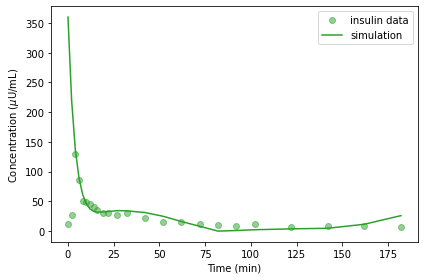

In [15]:
# Solution

data.insulin.plot(style='o', color='C2',
                  alpha=0.5, label='insulin data')
results.I.plot(style='-', color='C2', label='simulation')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:**  Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, call `run_solve_ivp`, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the parameters from the previous exercise.

Hint: As we did with the glucose model, you might want to drop the first few elements from the sequence of errors.

In [16]:
# Solution

def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    actual: array of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)

    # solve the ODE
    results, details = run_solve_ivp(system, slope_func,
                                     t_eval=data.index)

    # compute the difference between the model
    # results and actual data
    errors = results.I - data.insulin
    return errors.iloc[2:]

In [17]:
# Solution

error_func(params, data)

(360, 0.25, 0.004, 80)


4       7.706929
6       4.524430
8      10.658402
10     -3.246061
12     -7.908701
14     -7.999506
16     -3.582003
19      1.868456
22      2.623064
27      7.112415
32      3.812025
42      8.935032
52      9.596202
62      0.792766
72     -3.207047
82    -10.351188
92     -7.392451
102    -9.062922
122    -3.584825
142    -3.565963
162     3.180971
182    18.705197
dtype: float64

**Exercise:** Use `leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

In [ ]:
# Solution

best_params, details = leastsq(error_func, params, data)

In [21]:
# Solution

details.mesg

'The relative error between two consecutive iterates is at most 0.000000'

In [24]:
# Solution

system2 = make_system(best_params, data)

In [25]:
# Solution

results2, details = run_solve_ivp(system2, slope_func, 
                                  t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

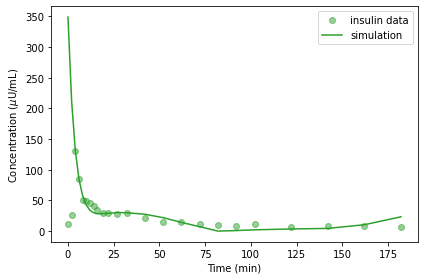

In [27]:
# Solution

data.insulin.plot(style='o', color='C2',
                  alpha=0.5, label='insulin data')
results2.I.plot(style='-', color='C2', label='simulation')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:** Using the best parameters, estimate the sensitivity to glucose of the first and second phase pancreatic responsivity:

$ \phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)} $

$ \phi_2 = \gamma \times 10^4 $

For $G_0$, use the best estimate from the glucose model, 290.  For $G_b$ and $I_b$, use the inital measurements from the data.


In [28]:
# Solution

I0, k, gamma, G_T = best_params

In [29]:
# Solution

I_max = data.insulin.max()
Ib = data.insulin[0]
I_max, Ib

(130, 11)

In [30]:
# Solution

# The value of G0 is the best estimate from the glucose model
G0 = 289
Gb = data.glucose[0]
G0, Gb

(289, 92)

In [31]:
# Solution

phi_1 = (I_max - Ib) / k / (G0 - Gb)
phi_1

2.3911679236237946

In [41]:
# Solution

phi_2 = gamma * 1e4
phi_2

35.66311848930756

In [39]:
phi_1_interval = 2, 4
phi_1_interval

(2, 4)

In [40]:
phi_2_interval = 20, 35
phi_2_interval

(20, 35)